<a href="https://colab.research.google.com/github/flecue/xai-aaai2021/blob/main/XAI_LIME%2BAnchor%2BSHAP%2BSaliency%2BGradCam%2BExMatchina_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CREDITS: https://github.com/nesl/Explainability-Study

Used as part of AAAI 2021 Tutorial on XAI - https://xaitutorial2021.github.io/
                                          - https://github.com/flecue/xai-aaai2021

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Configuration

1- Make sure to get "XAI_EXAMPLE_exMatchina_ALL" from https://github.com/flecue/xai-aaai2021/tree/main/XAI_EXAMPLE_exMatchina_ALL

In [ ]:
%cd '/content/gdrive/MyDrive/dev'
%ls

/content/gdrive/MyDrive/dev
pulse/
requirements_XAI_LIME+Anchor+SHAP+Saliency+GradCam+ExMatchina_Image.txt
XAI_EXAMPLE_exMatchina_ALL/
XAI_EXAMPLE_exMatchina_ECG.ipynb
XAI_EXAMPLE_exMatchina_Image.ipynb
XAI_EXAMPLE_exMatchina_Text.ipynb
XAI_LIME+Anchor+SHAP+Saliency+GradCam+ExMatchina_Image.ipynb


In [ ]:
!pip3 install -r requirements_XAI_LIME+Anchor+SHAP+Saliency+GradCam+ExMatchina_Image.txt

     |████████████████████████████████| 110.5MB 36kB/s 
     |████████████████████████████████| 13.1MB 252kB/s 
     |████████████████████████████████| 266kB 54.9MB/s 
     |████████████████████████████████| 20.0MB 66.2MB/s 
     |████████████████████████████████| 6.9MB 49.6MB/s 
     |████████████████████████████████| 225kB 54.3MB/s 
     |████████████████████████████████| 276kB 54.7MB/s 
     |████████████████████████████████| 378kB 50.5MB/s 
     |████████████████████████████████| 788kB 31.8MB/s 
     |████████████████████████████████| 2.1MB 39.3MB/s 
     |████████████████████████████████| 3.3MB 54.7MB/s 
     |████████████████████████████████| 10.0MB 43.7MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 3.8MB 39.4MB/s 
     |████████████████████████████████| 512kB 49.7MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 26.9MB 169kB/s 
     |████████████████████████████████| 358kB 46.7

2- Make sure to get to right path

In [ ]:
%cd '/content/gdrive/MyDrive/dev'

/content/gdrive/MyDrive/dev


In [ ]:
%ls XAI_EXAMPLE_exMatchina_ALL/Examples/

data/  Trained_Models/


3 - Make sure to get "data/" from https://drive.google.com/drive/folders/1ZRWIeUHxGbKpqWkJ2HpiSLtmUyllfThf

# Setup

In [ ]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import itertools
from random import randint
from skimage.segmentation import slic, mark_boundaries, felzenszwalb, quickshift
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import cv2
import numpy as np

import shap
from alibi.explainers import AnchorImage
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# import vis
# from vis.visualization import visualize_saliency

import sys
sys.path.append('./XAI_EXAMPLE_exMatchina_ALL')
from exmatchina import *


In [ ]:
num_classes = 10

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

class_dict = {
    'airplane': 0,
    'automobile':1,
    'bird':2,
    'cat':3,
    'deer':4,
    'dog':5,
    'frog':6,
    'horse':7,
    'ship':8,
    'truck':9
}

inv_class_dict = {v: k for k, v in class_dict.items()}

## These are the randomly generated indices that were used in our survey

# all_idx = np.array([23, 26, 390, 429, 570, 649, 732, 739, 1081, 1163, 1175, 1289, 1310, 1323
# , 1487, 1623, 1715, 1733, 1825, 1881, 1951, 2102, 2246, 2300, 2546, 2702, 2994, 3095
# , 3308, 3488, 3727, 3862, 4190, 4299, 4370, 4417, 4448, 4526, 4537, 4559, 4604, 4672
# , 4857, 5050, 5138, 5281, 5332, 5471, 5495, 5694, 5699, 5754, 5802, 5900, 6039, 6042
# , 6046, 6127, 6285, 6478, 6649, 6678, 6795, 7023, 7087, 7254, 7295, 7301, 7471, 7524
# , 7544, 7567, 7670, 7885, 7914, 7998, 8197, 8220, 8236, 8291, 8311, 8355, 8430, 8437
# , 8510, 8646, 8662, 8755, 8875, 8896, 8990, 9106, 9134, 9169, 9436, 9603, 9739, 9772
# , 9852, 9998])

all_idx = [23, 26, 390, 429, 570]    #Considering just 5 samples

In [ ]:
x_train = np.load('XAI_EXAMPLE_exMatchina_ALL/Examples/data/image/X_train.npy')
y_train = np.load('XAI_EXAMPLE_exMatchina_ALL/Examples/data/image/y_train.npy')
x_test = np.load('XAI_EXAMPLE_exMatchina_ALL/Examples/data/image/X_test.npy')
y_test = np.load('XAI_EXAMPLE_exMatchina_ALL/Examples/data/image/y_test.npy')

print(f'Number of Training samples: {x_train.shape[0]}')
print(f'Number of Test samples: {x_test.shape[0]}')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Number of Training samples: 50000
Number of Test samples: 10000
(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [ ]:
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

In [ ]:
model = load_model('XAI_EXAMPLE_exMatchina_ALL/Examples/Trained_Models/image.hdf5')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
Bn_2 (BatchNormalization

In [ ]:
def calculate_metrics(model, X_test, y_test_binary):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    #print(y_pred)
    y_true = np.argmax(y_test_binary, axis=1)
    # y_true = np.amax(y_true, axis=1) # Freddy
    #print(y_true)
    #print(np.amax(y_true, axis=1))
    mismatch = np.where(y_true != y_pred)
    #print(mismatch)
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    #micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return cf_matrix, accuracy, macro_f1, mismatch, y_pred

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        # print(cm)
    else:
        print('Confusion matrix, without normalization')
        # print(cm)

    plt.figure(figsize = (10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
  

Accuracy : 0.869
F1-score : 0.8683100113942105
Normalized confusion matrix


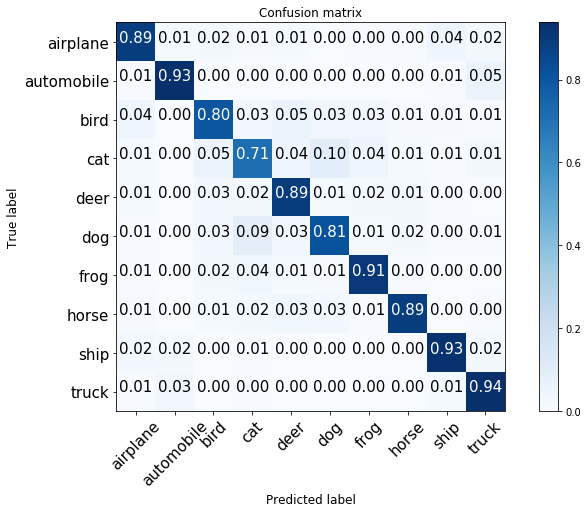

In [ ]:
cf_matrix, accuracy, macro_f1, mismatch, y_pred = calculate_metrics(model, x_test, y_test)

print('Accuracy : {}'.format(accuracy))
print('F1-score : {}'.format(macro_f1))

plot_confusion_matrix(cf_matrix, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

# LIME

truck


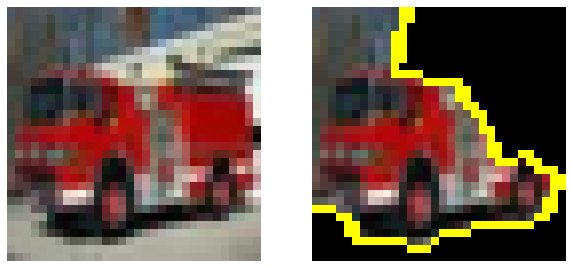

cat


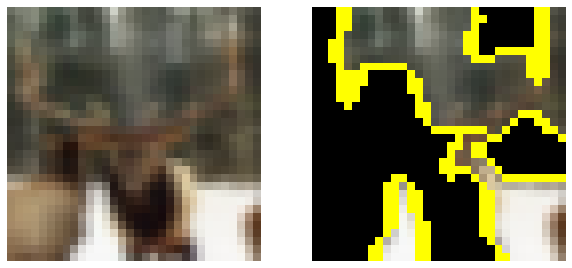

automobile


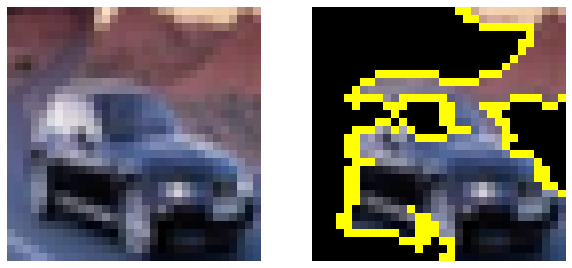

frog


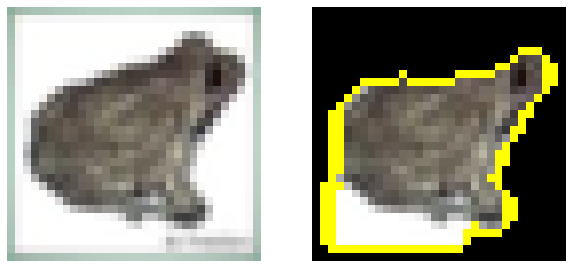

frog


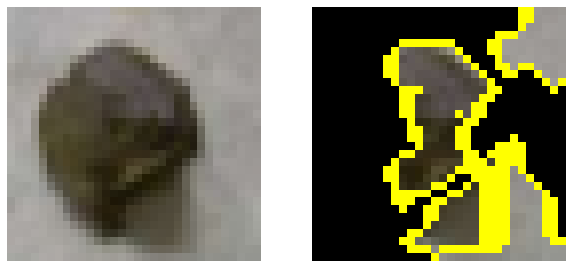

In [ ]:
explainer = lime_image.LimeImageExplainer()

segmentation_fn = SegmentationAlgorithm('felzenszwalb', scale=10,
                                                    sigma=0.4, min_size=20)

for i in all_idx:
    image = x_test[i]
    to_explain = np.expand_dims(image,axis=0)
    class_idx = np.argmax(model.predict(to_explain))
    print(inv_class_dict[class_idx])
    
    # Hide color is the color for a superpixel turned OFF. 
    # Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation = explainer.explain_instance(image, model.predict,segmentation_fn = segmentation_fn,
                                             top_labels=5, hide_color=0, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True, num_features=5, hide_rest=True)
    
    #Plotting
    fig, axes1 = plt.subplots(1,2, figsize=(10,10))
    # fig.suptitle(inv_class_dict[y_test[i]])
    axes1[0].set_axis_off()
    axes1[1].set_axis_off()
    axes1[0].imshow(x_test[i], interpolation='nearest')
    axes1[1].imshow(mark_boundaries(temp, mask), interpolation='nearest')
    # plt.savefig(f'./image/image-{i}-lime',bbox_inches = 'tight', pad_inches = 0.5)
    plt.show()

# Anchor Explanations

In [ ]:
# Define a Prediction Function
predict_fn = lambda x: model.predict(x)

image_shape = (32,32,3)
segmentation_fn = 'felzenszwalb'
slic_kwargs = {'n_segments': 100, 'compactness': 1, 'sigma': .5, 'max_iter': 50}
felzenszwalb_kwargs = {'scale': 10, 'sigma': 0.4, 'min_size': 50}

explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=felzenszwalb_kwargs, images_background=None)

truck


The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


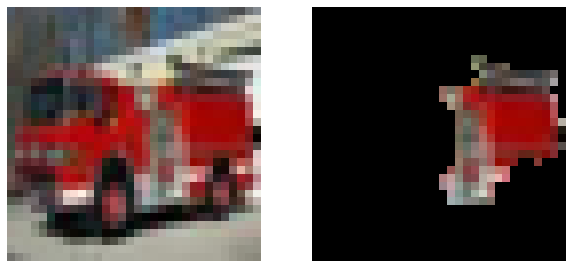

cat


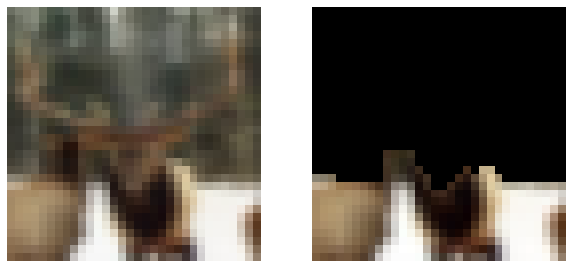

automobile


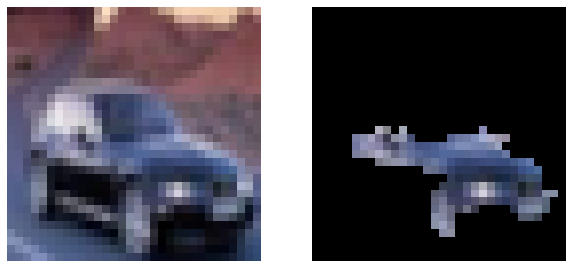

frog


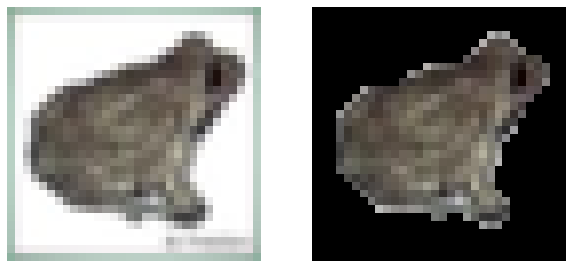

frog


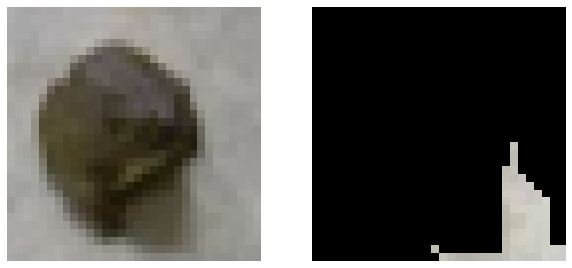

In [ ]:
for i in all_idx:

    image = x_test[i]
    to_explain = np.expand_dims(image,axis=0)
    class_idx = np.argmax(model.predict(to_explain))
    print(inv_class_dict[class_idx])
    
    explanation = explainer.explain(image, threshold=.99, p_sample=0.5, tau=0.15)
    
    ## Plotting
    fig, axes1 = plt.subplots(1,2, figsize=(10,10))
    # fig.suptitle(inv_class_dict[y_test[i]])
    axes1[0].set_axis_off()
    axes1[1].set_axis_off()
    axes1[0].imshow(x_test[i], interpolation='nearest')
    axes1[1].imshow(explanation['anchor'], interpolation='nearest')
    # plt.savefig(f'./image-{i}-anchor', bbox_inches = 'tight', pad_inches = 0.5)
    plt.show()

# SHAP

In [ ]:
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

# map input to specified layer 
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], x.reshape((1,) + x.shape)))
    return K.get_session().run(model.layers[layer].input, feed_dict)

def get_shap_full(idx):
    layer = 14
    to_explain = np.expand_dims(x_test[idx],axis=0)
    class_idx = np.argmax(model.predict(to_explain))
    print(inv_class_dict[class_idx])

    # get shap values
    e = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(background, layer))
    shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=1)

    # use SHAP plot
    shap.image_plot(shap_values, to_explain, show=False)

    # plt.savefig('./image/image-' + str(idx) + '-shap.png', bbox_inches='tight')


truck
cat
automobile
frog
frog


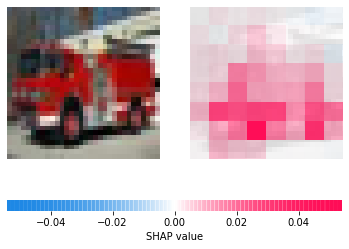

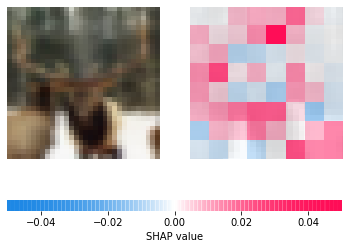

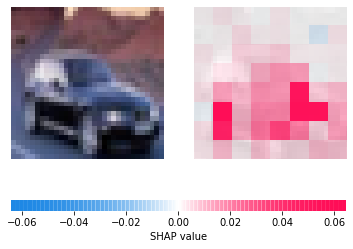

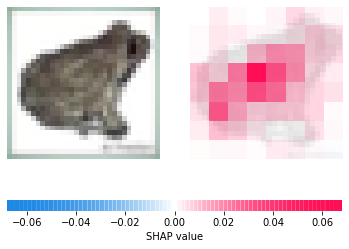

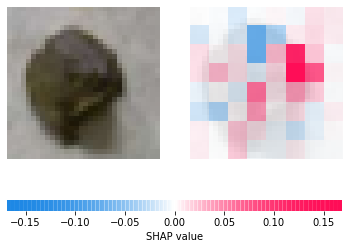

In [ ]:
for i in all_idx:
    get_shap_full(i)

# Saliency Map

In [ ]:
# Replace activation with linear
new_model = clone_model(model)
new_model.pop()
new_model.add(Activation('linear', name="linear_p"))

In [ ]:
new_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
Bn_2 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
Max_pool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 64)        18496   

In [ ]:
def plot_map(img_index, class_idx, grads):
    print(inv_class_dict[class_idx])
    fig, axes = plt.subplots(ncols=2,figsize=(8,6))
    axes[0].imshow(x_test[img_index])
    axes[0].axis('off')
    axes[1].imshow(x_test[img_index])
    axes[1].axis('off')
    i = axes[1].imshow(grads,cmap="jet",alpha=0.6)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([1, 0.2, 0.04, 0.59])
    fig.colorbar(i, cax=cbar_ax)
    
    # plt.savefig('./image/image-' + str(img_index) + '-saliencymap.png', bbox_inches='tight', pad_inches=0.3)
    # plt.close(fig)

    plt.show()


In [ ]:
def getSaliencyMap(img_index):
    
    to_explain = x_test[img_index].reshape(1,32,32,3)
    class_idx = np.argmax(model.predict(to_explain))
    print(class_idx)
    print(x_test[img_index].shape)

    grads = visualize_saliency(new_model,
                              14,
                              filter_indices = None,
                              seed_input = x_test[img_index])
    #plot_map(img_index, class_idx , grads)

In [ ]:
for i in all_idx:
    getSaliencyMap(i)
# getSaliencyMap(0)

NameError: ignored

# Grad-Cam++

In [ ]:
def get_gradcampp(idx):
    img = x_test[idx]
    cls_true = np.argmax(y_test[idx])
    
    x = np.expand_dims(img, axis=0)

    # get cam
    cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name="Conv_6")
    print(inv_class_dict[cls_pred])

    # resize to to size of image
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))

    fig, axes = plt.subplots(ncols=2,figsize=(8,6))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[1].imshow(img)
    axes[1].axis('off')
    i = axes[1].imshow(heatmap,cmap="jet",alpha=0.6)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([1, 0.2, 0.04, 0.60])
    fig.colorbar(i, cax=cbar_ax)

    # plt.savefig('./image/image-' + str(idx) + '-gradcampp.png', bbox_inches='tight', pad_inches=0.3)
    # plt.close(fig)
    plt.show()

def grad_cam_plus_plus(model, x, layer_name):   
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0)
    cam /= np.max(cam)

    return cls, cam

truck


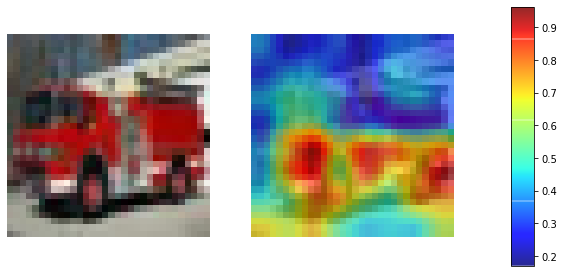

cat


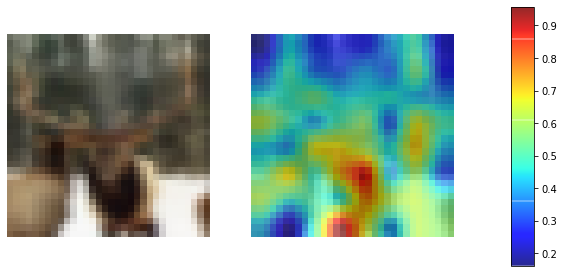

automobile


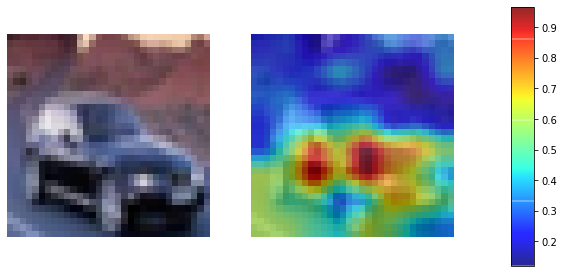

frog


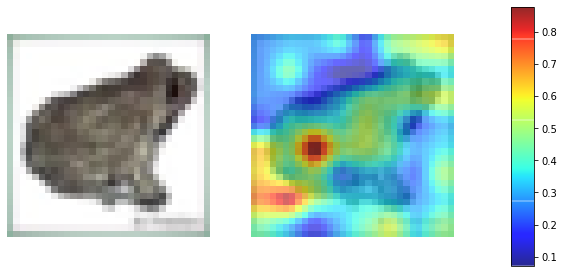

frog


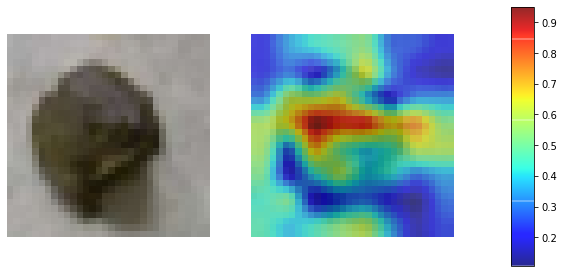

In [ ]:
for i in all_idx:
    get_gradcampp(i)

# ExMatchina

In [ ]:
def plot_images(test, examples, label):
        # =======GENERATE STUDY EXAMPLES=========
    fig = plt.figure(figsize=(10,3))
    num_display = 4
    fig.add_subplot(1, num_display, 1).title.set_text(inv_class_dict[label])
    plt.imshow(test, interpolation='nearest')
    plt.axis('off')
    line = fig.add_subplot(1, 1, 1)
    line.plot([2.39,2.39],[0,1],'--')
    line.set_xlim(0,10)
    line.axis('off')
    for k in range(num_display-1):
        if k >= len(examples):
            continue
        fig.add_subplot(1,num_display,k+2).title.set_text(inv_class_dict[label])
        fig.add_subplot(1,num_display,k+2).title.set_color('#0067FF')
        plt.imshow(examples[k], interpolation='nearest')
        plt.axis('off')
    
    fig.tight_layout()
    plt.tight_layout()
    plt.show()
    # plt.savefig('./image-' + str(i) + '-example.png', bbox_inches='tight')

In [ ]:
selected_layer = 'Flatten_1'

exm = ExMatchina(model=model, layer=selected_layer, examples=x_train)

Getting activations...
Getting labels...
Generating activation matrix...


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


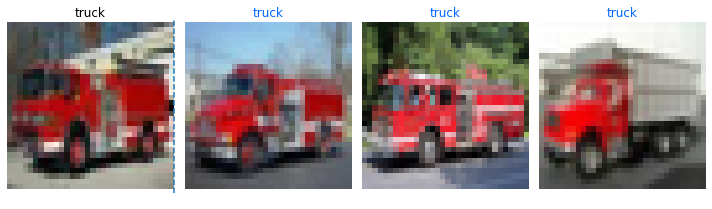

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


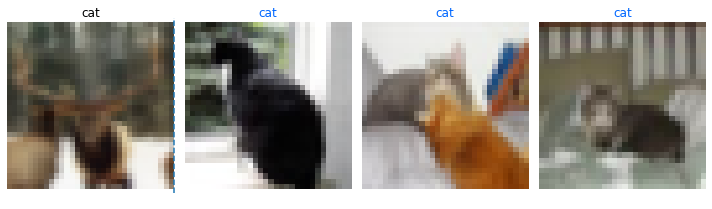

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


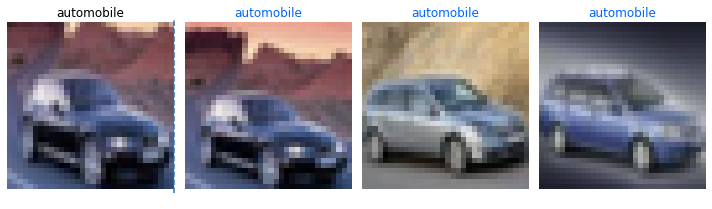

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


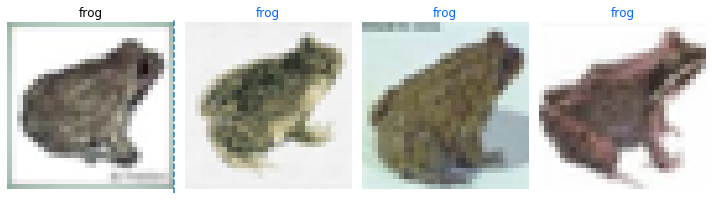

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


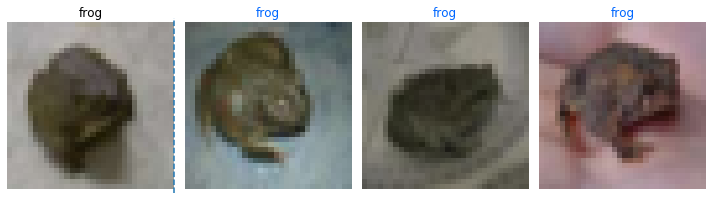

In [ ]:
for test_idx in all_idx:
    test_input = x_test[test_idx]
    label = exm.get_label_for(test_input)
    (examples, indices) = exm.return_nearest_examples(test_input)
    plot_images(test_input, examples, label)